In [17]:
%matplotlib inline
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Variable

In [18]:
from midox import midiread, midiwrite
import pretty_midi
from matplotlib import pyplot as plt
import skimage.io as io
from IPython.display import FileLink

from utils import *

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DataLoader

In [20]:
trainset = NotesGenerationDataset('./Nottingham/train/', longest_sequence_length=None)

trainset_loader = Data.DataLoader(trainset, batch_size=1, shuffle=True, drop_last=True)

In [21]:
X = next(iter(trainset_loader))
X[0].shape

keys_shape = X[0].shape[2]

In [22]:
valset = NotesGenerationDataset('./Nottingham/valid/', longest_sequence_length=None)

valset_loader = Data.DataLoader(valset, batch_size=1, shuffle=False, drop_last=False)

In [23]:
X_val = next(iter(valset_loader))
X_val[0].shape

torch.Size([1, 1229, 88])

# RNN

In [24]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, n_layers=2):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=hidden_size)
        
        self.bn = nn.BatchNorm1d(hidden_size)
        
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
        
        self.logits_fc = nn.Linear(hidden_size, num_classes)
    
    
    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        batch_size = input_sequences.shape[1]

        notes_encoded = self.notes_encoder(input_sequences)
        
        notes_encoded_rolled = notes_encoded.permute(1,2,0).contiguous()
        notes_encoded_norm = self.bn(notes_encoded_rolled)
        
        notes_encoded_norm_drop = nn.Dropout(0.25)(notes_encoded_norm)
        notes_encoded_complete = notes_encoded_norm_drop.permute(2,0,1)
        
        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(notes_encoded_complete, input_sequences_lengths)
        outputs, hidden = self.lstm(packed, hidden)
        
        # Here we unpack sequence(back to padded)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        
        outputs_norm = self.bn(outputs.permute(1,2,0).contiguous())
        outputs_drop = nn.Dropout(0.1)(outputs_norm)
        logits = self.logits_fc(outputs_drop.permute(2,0,1))
        logits = logits.transpose(0, 1).contiguous()
        
        neg_logits = (1 - logits)
        
        # Since the BCE loss doesn't support masking,crossentropy is used
        binary_logits = torch.stack((logits, neg_logits), dim=3).contiguous()
        logits_flatten = binary_logits.view(-1, 2)
        return logits_flatten, hidden

In [25]:
model = RNN(input_size=keys_shape, hidden_size=512, num_classes=keys_shape).to(device)

criterion = nn.CrossEntropyLoss().to(device)
criterion_val = nn.CrossEntropyLoss().to(device)

In [26]:
validate(model, valset_loader, criterion_val)

100%|██████████| 173/173 [00:04<00:00, 41.84it/s]


6.578323648951482e-05

In [27]:
clip = 1.0
epochs_number = 10
sample_history = []
best_val_loss = float("inf")

In [28]:
def lrfinder(start, end, model, trainset_loader, epochs=2):
    model.train() # into training mode
    lrs = np.linspace(start, end, epochs*len(trainset_loader))
    parameters = filter(lambda p: p.requires_grad, model.parameters()) # get all parameters which need grad
    optimizer = torch.optim.Adam(model.parameters(),start)
    loss_list = []
    ctr = 0
    
    for epoch_number in range(epochs):
        epoch_loss = []
        print('Epoch %d' % epoch_number)
        for batch in tqdm(trainset_loader):
            optimizer.param_groups[0]['lr'] = lrs[ctr]
            ctr = ctr+1

            post_processed_batch_tuple = post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple
            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).to(device) )
            input_sequences_batch_var = Variable( input_sequences_batch.to(device) )

            fake = input_sequences_batch_var[:, 0:1, :]

            # plt.figure(figsize=(10,6))
            # plt.imshow(fake.cpu().numpy().reshape((fake.shape[0],88)).transpose(0,1))

            optimizer.zero_grad()

            logits, _ = model(input_sequences_batch_var, sequences_lengths)

            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.item())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            epoch_loss.append(loss.item())
        
        print('Loss %.4f' % np.mean(epoch_loss))
    plt.plot(lrs, loss_list)
    return lrs, loss_list

 50%|█████     | 1/2 [00:31<00:31, 31.47s/it]

Epoch 0
Loss 1.6947


100%|██████████| 2/2 [01:02<00:00, 31.37s/it]


Epoch 1
Loss 10.4371


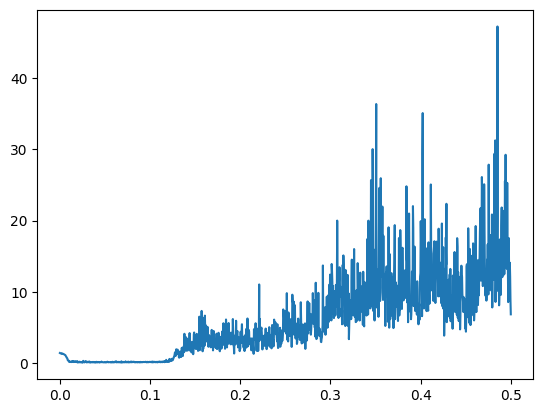

In [29]:
rnn = RNN(input_size=keys_shape, hidden_size=512, num_classes=keys_shape).to(device)
lrs, losses = lrfinder(1e-4, 1e-1*5, rnn, trainset_loader)

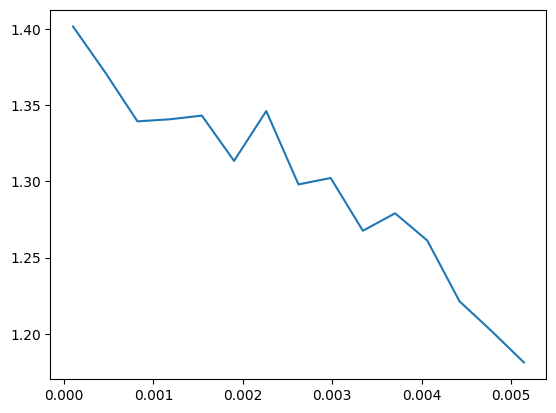

In [30]:
plt.plot(lrs[:15], losses[:15])

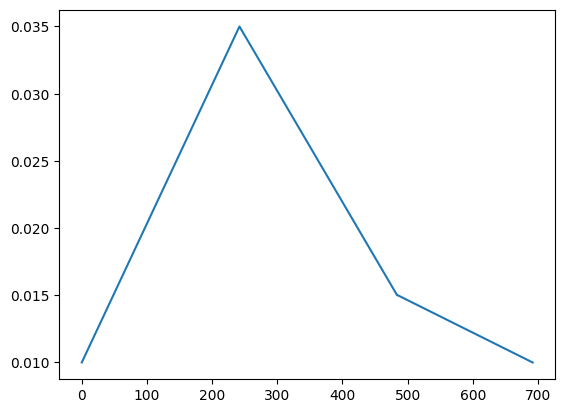

In [31]:
def get_triangular_lr(lr_low, lr_high, mini_batches):
    iterations = mini_batches
    lr_mid = lr_high/7 + lr_low
    up = np.linspace(lr_low, lr_high, int(round(iterations*0.35)))
    down = np.linspace(lr_high, lr_mid, int(round(iterations*0.35)))
    floor = np.linspace(lr_mid, lr_low, int(round(iterations*0.30)))
    return np.hstack([up, down[1:], floor])

lrs_triangular = get_triangular_lr(1e-2, 1e-2*3.5, len(trainset_loader))
plt.plot(lrs_triangular)

In [32]:
rnn = RNN(input_size=keys_shape, hidden_size=512, num_classes=keys_shape).to(device)
lrs_triangular = get_triangular_lr(1e-2, 1e-2*3.5, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular, trainset_loader, criterion, valset_loader, criterion_val)

  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: Epoch: 0 : 0.12494777198827232


 50%|█████     | 1/2 [00:33<00:33, 33.38s/it]

Validation Loss: Epoch: 0 : 6.0717884161978e-06

Training Loss: Epoch: 1 : 0.0940306045340444


100%|██████████| 2/2 [01:06<00:00, 33.48s/it]

Validation Loss: Epoch: 1 : 5.787054244086889e-06



In [33]:
lrs_triangular = get_triangular_lr(1e-3, 1e-2, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular, trainset_loader, criterion, valset_loader, criterion_val, epochs_number=2, wd=1e-4, best_val_loss=best_val_loss)

  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: Epoch: 0 : 0.08906277831139242


 50%|█████     | 1/2 [00:32<00:32, 32.82s/it]

Validation Loss: Epoch: 0 : 4.929944874677196e-06

Training Loss: Epoch: 1 : 0.0853574416661898


100%|██████████| 2/2 [01:05<00:00, 32.75s/it]

Validation Loss: Epoch: 1 : 4.709210062981896e-06



In [34]:
lrs_triangular = get_triangular_lr(1e-4, 1e-2, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular, trainset_loader, criterion, valset_loader, criterion_val, epochs_number=2, wd=1e-4*5, best_val_loss=best_val_loss)

  0%|          | 0/2 [00:00<?, ?it/s]

Training Loss: Epoch: 0 : 0.08886059358587182


 50%|█████     | 1/2 [00:33<00:33, 33.29s/it]

Validation Loss: Epoch: 0 : 5.1946118391523555e-06

Training Loss: Epoch: 1 : 0.08960200506410097


100%|██████████| 2/2 [01:06<00:00, 33.08s/it]

Validation Loss: Epoch: 1 : 5.483321908697093e-06



In [35]:
rnn.load_state_dict(torch.load('music_model_padfront_regularized.pth'))

<All keys matched successfully>

# Validation

In [46]:
def sample_from_piano_rnn(model, sample_length=4, temperature=1, starting_sequence=None):
    if starting_sequence is None:
        current_sequence_input = torch.zeros(1, 1, keys_shape)
        current_sequence_input[0, 0, 40] = 1
        current_sequence_input[0, 0, 50] = 0
        current_sequence_input[0, 0, 56] = 0
        current_sequence_input = Variable(current_sequence_input.to(device))
    else:
        current_sequence_input = starting_sequence
        
    final_output_sequence = [current_sequence_input.data.squeeze(1)]

    hidden = None

    for i in range(sample_length + 10):
        output, hidden = model(current_sequence_input, [1], hidden)

        probabilities = nn.functional.softmax(output.divide(temperature), dim=1)
        current_sequence_input = torch.multinomial(probabilities.data, 1).squeeze().unsqueeze(0).unsqueeze(1)
        current_sequence_input = Variable(current_sequence_input.float())
        final_output_sequence.append(current_sequence_input.data.squeeze(1))

    sampled_sequence = torch.cat(final_output_sequence[10:], dim=0).cpu().numpy()
    
    return sampled_sequence

In [37]:
testset = NotesGenerationDataset('./Nottingham/test/', longest_sequence_length=None)

testset_loader = Data.DataLoader(testset, batch_size=1,shuffle=True, drop_last=False)

In [38]:
batch = next(iter(testset_loader))
post_processed_batch_tuple = post_process_sequence_batch(batch)

input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

output_sequences_batch_var =  output_sequences_batch.contiguous().view(-1).to(device)

input_sequences_batch_var = input_sequences_batch.to(device)
input_sequences_batch_var.shape

torch.Size([160, 1, 88])

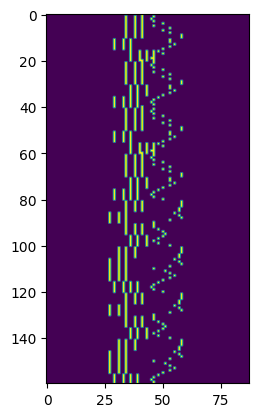

In [39]:
plt.imshow(input_sequences_batch_var.cpu().numpy().reshape((input_sequences_batch_var.shape[0],keys_shape)).transpose(0,1))

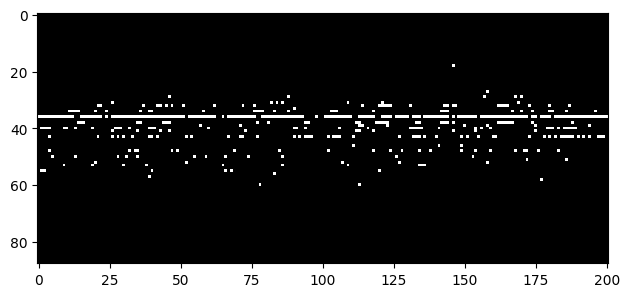

In [47]:
sample = sample_from_piano_rnn(rnn, sample_length=200, temperature=0.7, starting_sequence=X[0][:,:1,:].to(device)).transpose()
io.imshow(sample)
piano_roll = sample.transpose()

In [41]:
midiwrite('sample_reg_018.mid', piano_roll, dt=0.4)

# from pypianoroll import Multitrack, BinaryTrack
# piano_roll[:, 89:] = 0
# track_name = 'Piano'
# pianoroll_track = BinaryTrack(pianoroll=piano_roll, name=track_name)
# multitrack_name = 'MyMultitrack'  # Set a name for the multitrack
# multitrack = Multitrack(tracks=[pianoroll_track], name=multitrack_name, resolution=1)
# print(multitrack)
# multitrack.write('output.mid')

In [42]:
FileLink('sample_reg_018.mid')

/home/bhavb/Dev/SMAI/project-team-1/Music-Generation/notebooks/sample_reg_018.mid

In [43]:
# import IPython.display as ipd
# ipd.Audio('./sample_reg_018.mp3')